In [ ]:
# 2 inner channel without relu

In [ ]:
import h5py

##Setup

In [ ]:
import numpy as np
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib
import matplotlib as plt
import time
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from sklearn.mode_selection import train_test_split
from torchvision.utils import save_image
from PIL import image
from torchvision import transforms
#matplotlib.style.use('ggplot')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.insert(0,'/content/drive/My Drive/data/')

Mounted at /content/drive


In [ ]:
device= 'cuda :0' if torch.cuda_available( else 'cpu')
device

In [ ]:
import cv2 ############### ?????
import requests
from io import BytesIO

## Generate Labels

In [ ]:
## Gaussian Blur
r=33

sigma1 =4
mean1 = -4

sigma2= 4
mean2 = 7

x= np.arange(-r, r + 1)
x1= np.exp(-(x-mean1)**2/(2*sigma1**2))
x1= x1[np.newaxis, :] * x1[:, np.newaxis]
x1 = x1 / x1.sum()
x2 = np.exp(-(x-mean2)**2/(2*sigma2**2))
x2 = x2[np.newaxis,:] * x2[:,np.newaxis]
x2 = x2 / x2.sum()

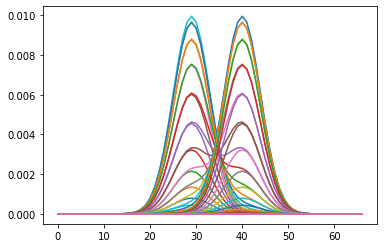

In [ ]:
plt.plot(x1+x2)

In [ ]:

class GaussianBlurring(object):

  def __init__(self, ker_size= 33):
    r = ker_size //2
    ker_size = r* 2 + 1
    self.u_blurr = nn.Conv2d(1, 1, kernel_size= (ker_size, ker_size), padding= (16,16), padding_mode= 'replicate', bias=False, group=1)
    self.v_blurr = nn.Conv2d(1, 1, kernel_size= (ker_size, ker_size), padding= (16,16), padding_mode= 'replicate', bias=False, group=1)

    self.k= ker_size
    self.r= r
    self.tensor_to_imgage = transforms.ToPILImage()

  def __init__(self, img):
    img=torch.tensor(np.asarry(img)).unsqueeze(0).float()
    img=img.unsqueeze(0).float()
    img=img.permute(0, 1, 2, 3)
    
    sigma1= 4
    mean1= -3

    sigma2= 4
    mean2= 7

    x= np.arange(-r, r + 1)

    x1= np.exp(-(x-mean1)**2/(2*sigma1**2))
    x1= x1[np.newaxis, :] * x1[:, np.newaxis]
    x1 = x1 / x1.sum()

    x2 = np.exp(-(x-mean2)**2/(2*sigma2**2))
    x2 = x2[np.newaxis,:] * x2[:,np.newaxis]
    x2 = x2 / x2.sum()

    x1 = torch.from_numpy(x1)
    x2=  torch.from_numpy(x2)

    self.u_blurr.weight.data.copy_(x1.view(1, 1, self.k, self.k))
    self.v_blurr.weight.data.copy_(x1.view(1, 1, self.k, self.k))

            with torch.no_grad():
            img1 = self.blur_h(img)
            img2 = self.blur_v(img)
            img = 0.5*(img1+img2).squeeze()

            with torch.no_grad():   ## NO gradiant updates here, because we want to generate labels.
            img1= self.blurr_u(img)
            img2= self.blurr_v(img)
            img= 0.5*(img1 + img2).squeeze() # superposition of Gaussian

In [ ]:
class GaussianBlur2(object):
    
    def __init__(self, kernel_size=33):
        radias = kernel_size // 2
        kernel_size = radias * 2 + 1
        #self.pad = nn.ReflectionPad2d(radias)
        #self.pad = nn.ReplicationPad2d(radias) ### capacity
        self.blur_h = nn.Conv2d(1, 1, kernel_size=(kernel_size, kernel_size),padding=(16,16),padding_mode='replicate', bias=False, groups=1) # padding=(16,16)
        self.blur_v = nn.Conv2d(1, 1, kernel_size=(kernel_size, kernel_size),padding=(16,16),padding_mode='replicate',bias=False, groups=1) #padding_mode='replicate'
        self.k = kernel_size
        self.r = radias

        self.tensor_to_pil = transforms.ToPILImage()

    def __call__(self, img):
        img = torch.tensor(np.asarray(img)).unsqueeze(0).float()
        img=img.unsqueeze(0).float() ###
        img = img.permute(0, 1, 2, 3)

        sigma1 = 4
        mean1 = -3

        sigma2 = 4
        mean2 = 7

        x = np.arange(-self.r, self.r + 1)
        x1 = np.exp(-(x-mean1)**2/(2*sigma1**2))
        x1 = x1[np.newaxis,:] * x1[:,np.newaxis]
        x1 = x1 / x1.sum()

        x2 = np.exp(-(x-mean2)**2/(2*sigma2**2))
        x2 = x2[np.newaxis,:] * x2[:,np.newaxis]
        x2 = x2 / x2.sum()

        x1 = torch.from_numpy(x1)#.view(1, -1).repeat(1, 1) #?
        x2 = torch.from_numpy(x2)#.view(1, -1).repeat(1, 1)

        self.blur_h.weight.data.copy_(x1.view(1, 1, self.k, self.k))
        self.blur_v.weight.data.copy_(x2.view(1, 1, self.k, self.k))

        with torch.no_grad():
            img1 = self.blur_h(img)
            img2 = self.blur_v(img)
            img = 0.5*(img1+img2).squeeze()


            ##img = self.tensor_to_pil((img / 255).float().cpu())

        return img

        #img = cv2.imread('/content/test_chelsea.png', 0)

        #torchimg = GaussianBlur2()(img)

In [ ]:
import os
import glob
import h5py
import cv2
from PIL import Image
import numpy as np

def mod_crop(image, scale = 3):
    if len(image.shape) ==3:
        h = image.shape[0]
        w = image.shape[1]
        h = h - np.mod(h,scale)
        w = w - np.mod(w,scale)
        return image[0:h,0:w,:]
    else:
        h = image.shape[0]
        w = image.shape[1]
        h = h - np.mod(h,scale)
        w = w - np.mod(w,scale)
        return image[0:h,0:w]

def sub_img(input, label, i_size = 66, l_size = 66, stride = 14):
    sub_ipt = []
    sub_lab = []
    pad = abs(i_size-l_size)//2

    for h in range(0, input.shape[0] - i_size + 1, stride):
        for w in range(0, input.shape[1] - l_size + 1, stride):
            sub_i = input[h:h+i_size,w:w+i_size]
            sub_l = label[h + pad :h + pad + l_size,w + pad :w + pad + l_size]
            sub_i = sub_i.reshape(1, i_size,i_size)
            sub_l = sub_l.reshape(1, l_size,l_size)
            sub_ipt.append(sub_i)
            sub_lab.append(sub_l)
    return sub_ipt, sub_lab

def load_img(file_path):
    dir_path = os.path.join(os.getcwd(), file_path)
    img_path = glob.glob(os.path.join(dir_path, '*.bmp'))
    return img_path

def read_img(img_path):
    # read image
    image = cv2.imread(img_path)
    # rgb > ycbcr
    image = cv2.cvtColor(image, cv2.COLOR_BGR2YCR_CB)
    image = image[:, :, 0]
    return image

def GB_img(img, scale): 
    label = img.astype('float') / 255
    input= GaussianBlur2()(label)
    input=input.numpy()
    return input, label

def img_rotate(img, degree):
    height, width = img.shape
    matrix = cv2.getRotationMatrix2D((width/2, height/2), 90*degree, 1)
    if degree == 1 or degree == 3:
        dst = cv2.warpAffine(img, matrix, (height, width))
    else:
        dst = cv2.warpAffine(img, matrix, (width, height))
    return dst

def save_h5(sub_ip, sub_la, savepath = '/content/drive/My Drive/data/oshi30mm.h5'):
    path = os.path.join(os.getcwd(), savepath)
    with h5py.File(path, 'w') as hf:
        hf.create_dataset('input', data=sub_ip)
        hf.create_dataset('label', data=sub_la)

def data_aug(file_path = '/content/drive/My Drive/data/Train', savepath = '/content/drive/My Drive/data/oshi30mm.h5', i_size = 66, l_size = 66, stride = 14):
    sub_ip = []
    sub_la = []
    num = 1
    img_path = load_img(file_path)
    for _ in img_path:
        image = read_img(_)
        for degree in [0.,1.,2.]:
            image_r = img_rotate(image, degree)
            for scale in [2,3]:
                md_image = mod_crop(image_r, scale)
                input, label = GB_img(md_image, scale)
                sub_ipt, sub_lab = sub_img(input, label, i_size, l_size, stride)
                sub_ip += sub_ipt
                sub_la += sub_lab
        print('data no.',num)
        num += 1
    sub_ip = np.asarray(sub_ip)
    sub_la = np.asarray(sub_la)
    print('input shape : ',sub_ip.shape)
    print('label shape0* : ',sub_la.shape)
    save_h5(sub_ip, sub_la, savepath)
    print('---------save---------')

if __name__ == '__main__':
    print('starting data augmentation...')
    data_aug()

starting data augmentation...
data no. 1
data no. 2
data no. 3
data no. 4
data no. 5
data no. 6
data no. 7
data no. 8
data no. 9
data no. 10
data no. 11
data no. 12
data no. 13
data no. 14
data no. 15
data no. 16
data no. 17
data no. 18
data no. 19
data no. 20
data no. 21
data no. 22
data no. 23
data no. 24
data no. 25
data no. 26
data no. 27
data no. 28
data no. 29
data no. 30
data no. 31
data no. 32
data no. 33
data no. 34
data no. 35
data no. 36
data no. 37
data no. 38
data no. 39
data no. 40
data no. 41
data no. 42
data no. 43
data no. 44
data no. 45
data no. 46
data no. 47
data no. 48
data no. 49
data no. 50
data no. 51
data no. 52
data no. 53
data no. 54
data no. 55
data no. 56
data no. 57
data no. 58
data no. 59
data no. 60
data no. 61
data no. 62
data no. 63
data no. 64
data no. 65
data no. 66
data no. 67
data no. 68
data no. 69
data no. 70
data no. 71
data no. 72
data no. 73
data no. 74
data no. 75
data no. 76
data no. 77
data no. 78
data no. 79
data no. 80
data no. 81
data no

In [ ]:
def data_aug_example(file_path = '/content/drive/My Drive/data/Train', 
i_size = 66, l_size = 66, stride = 14):
    sub_ip = []
    sub_la = []
    num = 1
    img_path = load_img(file_path)
    for _ in img_path:
        if num>1:
          continue
        image = read_img(_)
        for degree in [0.]: #,1.,2.,3.]:
            image_r = img_rotate(image, degree)
            for scale in [2]: #,3,4]:
                md_image = mod_crop(image_r, scale)
                input, label = GB_img(md_image, scale)
                sub_ipt, sub_lab = sub_img(input, label, i_size, l_size, stride)
                sub_ip.append(sub_ipt)
                sub_la.append(sub_lab)
        print('data no.',num)
        num += 1
    sub_ip = np.asarray(sub_ip)
    sub_la = np.asarray(sub_la)

    return sub_ip, sub_la

a,b= data_aug_example(file_path = '/content/drive/My Drive/data/Train')

data no. 1


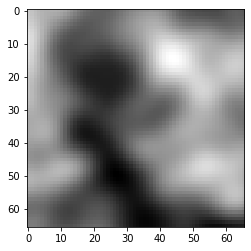

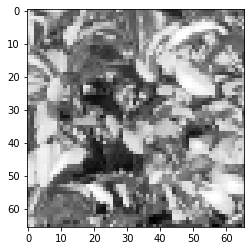

In [ ]:
b.shape

plt.imshow(a[0,0,0],cmap="gray")
plt.show()
plt.imshow(b[0,0,0],cmap="gray")
plt.show()

In [ ]:
class Anet(nn.Module):
    def __init__(self, inner_chnl=4):
        super(Anet, self).__init__()
        self.channel=channel
        self.conv1 = nn.Conv2d(1, self.inner_chnl, kernel_size=(65,1),padding=(32,0), padding_mode='circular', bias=False, groups=1) #circular
        self.conv2 = nn.Conv2d(self.inner_chnl, 1, kernel_size=(1,65),padding=(0,32), padding_mode='circular',bias=False, groups=1)
        #groups
    def forward(self, x):
        x1 =self.conv1(x)
        out =self.conv2(x1)
        
        #U = self.conv1.weight.detach().clone()
        #V = self.conv2.weight.detach().clone()
        return out
A_net = Anet() #.to(device)
mse = nn.MSELoss()
x = torch.randn(1, 1, 65, 65)
A_net(x).shape

In [ ]:
class Anet(nn.module):
  def__init__(self, inner_chnl=2):
      super(Anet, self).__init__()
      self.inner_chnl= channel
      self.conv1= nn.conv2d(1, self.inner_chnl, kernel_size=(33,1), padding=(16,0), padding_mode='replicate', bias=False, group=1)
      self.conv2= nn.conv2d(self.inner_chnl, 1, kernel_size=(1,33), padding=(0,16), padding_mode='replicate', bias=False, group=1)

 def forward(self, x):
   x1=self.conv1(x)
   #x1=F.relu(self.conv1(x))
   x2=self.conv2(x1)
   #x2=F.relu(self.conv2(x1))

   ### convolution kernels
   U = model.conv1.weight.detach().clone()
   V =model.conve2.weight.detach().clone()
   
   return X2, X1, U, V

A_net= Anet().to(device)
print(A_net)

In [ ]:
class Anet(nn.Module):
    def __init__(self):
        super(Anet, self).__init__()
        self.conv1 = nn.Conv2d(1, 2, kernel_size=(33,1),padding=(16,0),padding_mode='replicate', bias=False, groups=1) #replicate ### 4 channel #padding=(16,0),padding_mode='circular',
       
        self.conv2 = nn.Conv2d(2, 1, kernel_size=(1,33), padding=(0,16),padding_mode='replicate',bias=False, groups=1)#groups
    def forward(self, x):
        x1 =self.conv1(x)
        #x2 = F.relu(self.conv2(x1))
        x2 = self.conv2(x1)

        U = model.conv1.weight.detach().clone()
        V = model.conv2.weight.detach().clone()
        return x2,x1,U,V
model = Anet().to(device)
print(model)

Anet(
  (conv1): Conv2d(1, 2, kernel_size=(33, 1), stride=(1, 1), padding=(16, 0), bias=False, padding_mode=replicate)
  (conv2): Conv2d(2, 1, kernel_size=(1, 33), stride=(1, 1), padding=(0, 16), bias=False, padding_mode=replicate)
)


In [ ]:
# parameters
batch_size = 64 
epochs = 50
lr = 0.001 
#device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
# input image dimensions
img_rows, img_cols = 66, 66
out_rows, out_cols = 66, 66

In [ ]:
file = h5py.File('/content/drive/My Drive/data/oshi30mm.h5') ### sigma=7
#file = h5py.File('/content/drive/My Drive/data/train21F.h5') ###sigma=2
#file = h5py.File('/content/drive/My Drive/data/train2m.h5') ### sigma=7
# `in_train` has shape (21884, 33, 33, 1) which corresponds to
# 21884 image patches of 33 pixels height & width and 1 color channel

###################
###in_train = file['input'][:] # the training data
###out_train = file['label'][:] # the training labels
##################

out_train = file['input'][:] # the training labels
in_train = file['label'][:] # the training data #
file.close()
# change the values to float32
in_train = in_train.astype('float32')
out_train = out_train.astype('float32')

In [ ]:
(x_train, x_val, y_train, y_val) = train_test_split(in_train, out_train, test_size=0.25)
print('Training samples: ', x_train.shape[0])
print('Validation samples: ', x_val.shape[0])

Training samples:  72420
Validation samples:  24141


In [ ]:
# the dataset module
class AnetDataset(Dataset):
    def __init__(self, image_data, labels):
        self.image_data = image_data
        self.labels = labels
    def __len__(self):
        return (len(self.image_data))
    def __getitem__(self, index):
        image = self.image_data[index]
        label = self.labels[index]
        return (
            torch.tensor(image, dtype=torch.float),
            torch.tensor(label, dtype=torch.float)
        )

In [ ]:
# train and validation data
train_data = AnetDataset(x_train, y_train)
val_data = AnetDataset(x_val, y_val)
# train and validation loaders
train_loader = DataLoader(train_data, batch_size=batch_size)
val_loader = DataLoader(val_data, batch_size=batch_size)

In [ ]:
# initialize the model
print('Computation device: ', device)
#model = anet.Anet().to(device)
model = Anet().to(device)
#print(model)
model

Computation device:  cpu


Anet(
  (conv1): Conv2d(1, 2, kernel_size=(33, 1), stride=(1, 1), padding=(16, 0), bias=False, padding_mode=replicate)
  (conv2): Conv2d(2, 1, kernel_size=(1, 33), stride=(1, 1), padding=(0, 16), bias=False, padding_mode=replicate)
)

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau( 
#        optimizer,
#        mode='min',
#        patience=5,
#        factor=0.5,
#        verbose=True
#    )

In [ ]:
import math

In [ ]:
def user_loss(recon_y, y, U, V, alpha=0.0001):

    E = torch.subtract(y, recon_y)
    #print(y.shape)  
    #print(recon_y.shape)  
    #print(E.shape)  
    sumE2 = torch.sum(E.pow(2.0)) ### torch mul and pow black img and nan values!!!
    sumU2 = torch.sum(U.pow(2.0))
    sumV2 = torch.sum(V.pow(2.0))

    obj = sumE2 + alpha*(sumU2 + sumV2) 

    return obj

In [ ]:
def train(model, dataloader):
    model.train()
    running_loss = 0.0
    ##running_psnr = 0.0
    for bi, data in tqdm(enumerate(dataloader), total=int(len(train_data)/dataloader.batch_size)):
        image_data = data[0].to(device)
        label = data[1].to(device)
        
        # zero grad the optimizer
        optimizer.zero_grad()
        #outputs = model(image_data)
        x2,_, U, V  = model(image_data)
        #outputs, U, V  = model(image_data)
        l2_norm = sum(p.pow(2.0).sum() for p in model.parameters()) # L2 norm of the weights
        obj=nn.MSELoss()
        loss = obj(x2, label)
        loss= loss +  0.01*l2_norm #adding L2 regularization to loss
        #loss = user_loss(x2, label,U,V)
        # backpropagation
        loss.backward()
        # update the parameters
        optimizer.step()
        # add loss of each item (total items in a batch = batch size)
        running_loss += loss.item()
        # calculate batch psnr (once every `batch_size` iterations)
        ##batch_psnr =  psnr(label, outputs)
        ##running_psnr += batch_psnr
    final_loss = running_loss/len(dataloader.dataset)
    #final_psnr = running_psnr/int(len(train_data)/dataloader.batch_size)
    return final_loss ## final_psnr

In [ ]:
def validate(model, dataloader, epoch):
    model.eval()
    running_loss = 0.0
    ##running_psnr = 0.0
    with torch.no_grad():
        for bi, data in tqdm(enumerate(dataloader), total=int(len(val_data)/dataloader.batch_size)):
            image_data = data[0].to(device)
            label = data[1].to(device)
            x2,_, U, V  = model(image_data)
        #outputs, U, V  = model(image_data)
            l2_norm = sum(p.pow(2.0).sum() for p in model.parameters()) ###########
            obj=nn.MSELoss()
            loss = obj(x2, label)
            loss= loss +  0.01*l2_norm ######################
            #outputs, U, V = model(image_data)
            #loss = user_loss(x2, label,U,V)
            # add loss of each item (total items in a batch = batch size) 
            running_loss += loss.item()
            # calculate batch psnr (once every `batch_size` iterations)
            ##batch_psnr = psnr(label, outputs)
            ##running_psnr += batch_psnr
        outputs = x2.cpu()
        save_image(outputs, f"/content/drive/My Drive/outs30mm/val{epoch}.png")
        save_image(label.cpu(), f"/content/drive/My Drive/outsRef30mm/ref{epoch}.png")
        #save_image(outputs, f"/content/drive/My Drive/outs2m/val{epoch}.png")
        #save_image(outputs, f"/content/drive/My Drive/outs9f/val{epoch}.png")
    final_loss = running_loss/len(dataloader.dataset)
    ##final_psnr = running_psnr/int(len(val_data)/dataloader.batch_size)
    return final_loss ##, final_psnr

In [ ]:
train_loss, val_loss = [], []
##train_psnr, val_psnr = [], []
start = time.time()
for epoch in range(epochs):
    print(f"Epoch {epoch + 1} of {epochs}")
    train_epoch_loss= train(model, train_loader)
    val_epoch_loss = validate(model, val_loader, epoch)
    ##print(f"Train PSNR: {train_epoch_psnr:.3f}")
    ##print(f"Val PSNR: {val_epoch_psnr:.3f}")
    train_loss.append(train_epoch_loss)
    ##train_psnr.append(train_epoch_psnr)
    val_loss.append(val_epoch_loss)
    ##val_psnr.append(val_epoch_psnr)
end = time.time()
print(f"Finished training in: {((end-start)/60):.3f} minutes")

Epoch 1 of 50


1132it [02:44,  6.88it/s]
378it [00:11, 32.67it/s]                         


Epoch 2 of 50


1132it [02:39,  7.09it/s]                          
378it [00:11, 31.95it/s]                         


Epoch 3 of 50


1132it [02:36,  7.22it/s]                          
378it [00:11, 32.56it/s]


Epoch 4 of 50


1132it [02:32,  7.41it/s]                          
378it [00:11, 34.05it/s]                         


Epoch 5 of 50


1132it [02:32,  7.44it/s]                          
378it [00:11, 34.01it/s]                         


Epoch 6 of 50


1132it [02:36,  7.22it/s]                          
378it [00:11, 33.84it/s]                         


Epoch 7 of 50


1132it [02:31,  7.46it/s]                          
378it [00:11, 33.88it/s]                         


Epoch 8 of 50


1132it [02:31,  7.45it/s]                          
378it [00:11, 34.27it/s]                         


Epoch 9 of 50


1132it [02:32,  7.43it/s]                          
378it [00:12, 31.22it/s]                         


Epoch 10 of 50


1132it [02:34,  7.32it/s]                          
378it [00:11, 34.06it/s]                         


Epoch 11 of 50


1132it [02:32,  7.45it/s]                          
378it [00:11, 34.06it/s]                         


Epoch 12 of 50


1132it [02:31,  7.46it/s]                          
378it [00:11, 34.08it/s]                         


Epoch 13 of 50


1132it [02:32,  7.40it/s]                          
378it [00:11, 33.60it/s]                         


Epoch 14 of 50


1132it [02:31,  7.47it/s]                          
378it [00:10, 34.62it/s]                         


Epoch 15 of 50


1132it [02:31,  7.48it/s]                          
378it [00:11, 31.96it/s]                         


Epoch 16 of 50


1132it [02:32,  7.43it/s]                          
378it [00:11, 33.87it/s]                         


Epoch 17 of 50


1132it [02:31,  7.48it/s]                          
378it [00:10, 34.41it/s]                         


Epoch 18 of 50


1132it [02:31,  7.49it/s]                          
378it [00:11, 34.36it/s]                         


Epoch 19 of 50


1132it [02:31,  7.47it/s]                          
378it [00:10, 34.38it/s]                         


Epoch 20 of 50


1132it [02:31,  7.47it/s]                          
378it [00:11, 34.20it/s]                         


Epoch 21 of 50


1132it [02:36,  7.21it/s]                          
378it [00:11, 32.55it/s]                         


Epoch 22 of 50


1132it [02:37,  7.18it/s]                          
378it [00:11, 32.33it/s]                         


Epoch 23 of 50


1132it [02:37,  7.17it/s]                          
378it [00:11, 32.56it/s]                         


Epoch 24 of 50


1132it [02:40,  7.04it/s]                          
378it [00:11, 32.09it/s]                         


Epoch 25 of 50


1132it [02:37,  7.19it/s]                          
378it [00:11, 32.92it/s]                         


Epoch 26 of 50


1132it [02:36,  7.23it/s]                          
378it [00:11, 32.88it/s]                         


Epoch 27 of 50


1132it [02:35,  7.29it/s]                          
378it [00:11, 32.42it/s]                         


Epoch 28 of 50


1132it [02:36,  7.22it/s]                          
378it [00:11, 33.35it/s]                         


Epoch 29 of 50


1132it [02:35,  7.29it/s]                          
378it [00:11, 32.84it/s]                         


Epoch 30 of 50


1132it [02:35,  7.29it/s]                          
378it [00:11, 33.48it/s]                         


Epoch 31 of 50


1132it [02:34,  7.31it/s]                          
378it [00:11, 32.55it/s]                         


Epoch 32 of 50


1132it [02:36,  7.23it/s]                          
378it [00:11, 33.04it/s]                         


Epoch 33 of 50


1132it [02:35,  7.27it/s]                          
378it [00:11, 33.09it/s]                         


Epoch 34 of 50


1132it [02:34,  7.33it/s]                          
378it [00:11, 32.21it/s]                         


Epoch 35 of 50


1132it [02:40,  7.06it/s]                          
378it [00:11, 33.09it/s]                         


Epoch 36 of 50


1132it [02:34,  7.33it/s]                          
378it [00:11, 32.76it/s]                         


Epoch 37 of 50


1132it [02:34,  7.31it/s]                          
378it [00:11, 33.08it/s]                         


Epoch 38 of 50


1132it [02:34,  7.30it/s]                          
378it [00:11, 33.23it/s]                         


Epoch 39 of 50


1132it [02:35,  7.27it/s]                          
378it [00:11, 32.62it/s]                         


Epoch 40 of 50


1132it [02:38,  7.16it/s]                          
378it [00:11, 32.37it/s]                         


Epoch 41 of 50


1132it [02:35,  7.30it/s]                          
378it [00:11, 33.41it/s]                         


Epoch 42 of 50


1132it [02:36,  7.25it/s]                          
378it [00:11, 32.70it/s]                         


Epoch 43 of 50


1132it [02:34,  7.30it/s]                          
378it [00:11, 32.58it/s]                         


Epoch 44 of 50


1132it [02:35,  7.27it/s]                          
378it [00:11, 33.30it/s]                         


Epoch 45 of 50


1132it [02:37,  7.17it/s]                          
378it [00:12, 30.47it/s]


Epoch 46 of 50


1132it [02:44,  6.87it/s]                          
378it [00:12, 30.45it/s]                         


Epoch 47 of 50


1132it [02:43,  6.92it/s]                          
378it [00:12, 30.69it/s]


Epoch 48 of 50


1132it [02:43,  6.92it/s]                          
378it [00:12, 29.51it/s]                         


Epoch 49 of 50


1132it [02:44,  6.89it/s]                          
378it [00:12, 30.23it/s]                         


Epoch 50 of 50


1132it [02:36,  7.23it/s]                          
378it [00:11, 32.75it/s]                         


Finished training in: 139.569 minutes


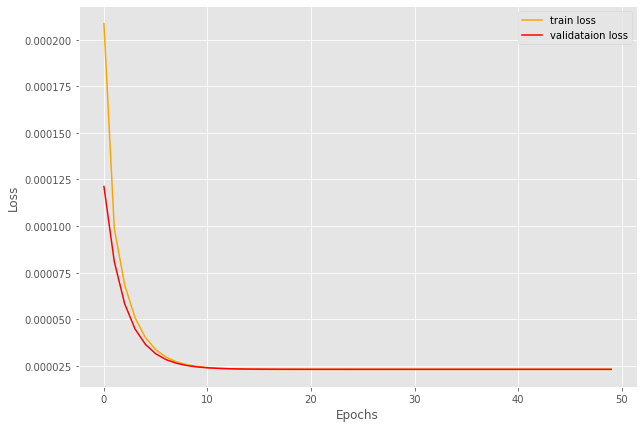

In [ ]:
# loss plots
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validataion loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('/content/drive/My Drive/losss30mm.png')
plt.show()

In [ ]:
# save the model to disk
print('Saving model...')
torch.save(model.state_dict(), '/content/drive/My Drive/model30mm.pth')
#torch.save(model.state_dict(), '/content/drive/My Drive/modelJMs.pth')

Saving model...


In [ ]:

import cv2

import glob as glob
import os


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.insert(0,'/content/drive/My Drive/model30mm.pth/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
model = model.to(device)
model
#model=model.cpu()
#model.load_state_dict(torch.load('/content/drive/My Drive/model18.pth'))

Anet(
  (conv1): Conv2d(1, 2, kernel_size=(33, 1), stride=(1, 1), padding=(16, 0), bias=False, padding_mode=replicate)
  (conv2): Conv2d(2, 1, kernel_size=(1, 33), stride=(1, 1), padding=(0, 16), bias=False, padding_mode=replicate)
)

In [ ]:
from google.colab.patches import cv2_imshow

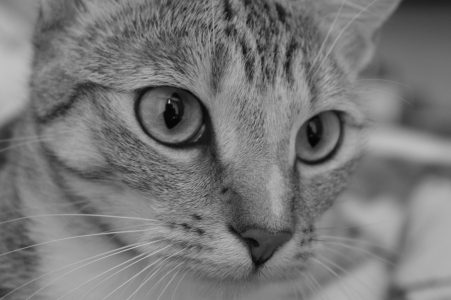

(300, 451, 1)


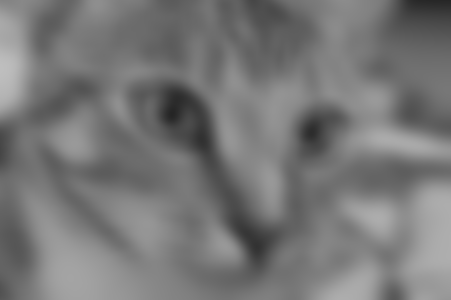

In [ ]:
### test phase
image_paths = glob.glob('/content/drive/My Drive/test_chelsea/test_chelsea*')
#image_paths = glob.glob('/content/drive/My Drive/MYout17jj.png*')
for image_path in image_paths:
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    test_image_name = image_path.split(os.path.sep)[-1].split('.')[0]
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = image.reshape(image.shape[0], image.shape[1], 1)
    cv2.imwrite(f"/content/drive/My Drive/catcake30mm.png", image)
    image = image #/ 255
    
    #cv2.imshow('Greyscale image', image)
    cv2_imshow(image)
    cv2.waitKey(0)
    model.eval()
    with torch.no_grad():
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)
        image = torch.tensor(image, dtype=torch.float).to(device)
        image = image.unsqueeze(0)
        x2,_, _,_= model(image)
        outputs = x2.cpu()
        #outputs, _, _ = model(image)
        #outputs = outputs.cpu()
    save_image(outputs, f"/content/drive/My Drive/MYcatcake30mm.png")
    outputs = outputs.detach().numpy()
    outputs = outputs.reshape(outputs.shape[2], outputs.shape[3], outputs.shape[1])
    print(outputs.shape)
    #cv2.imshow('Output', outputs)
    cv2_imshow(outputs)
    cv2.waitKey(0)

In [ ]:
#plt.imshow(outF, cmap='gray', vmin=0, vmax=255)

In [ ]:
model.eval()
model.cpu
image.cpu
x2,_,U,V = model(image)

U=U.squeeze(1)
V=V.squeeze(0)
U.shape
U=U.cpu()
V=V.cpu()

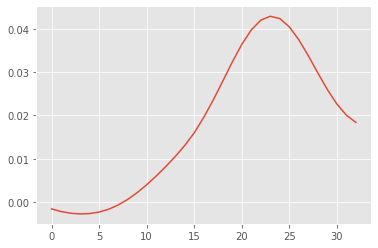

In [ ]:
U.shape

plt.plot(U[0])
#plt.plot(U[1])

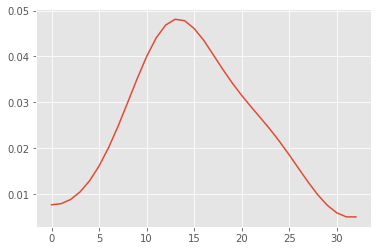

In [ ]:
plt.plot(U[1])

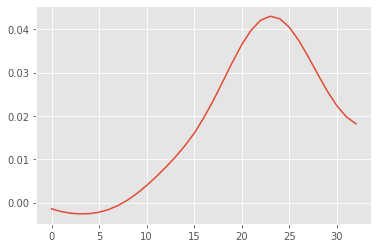

In [ ]:
plt.plot(V[0].T)

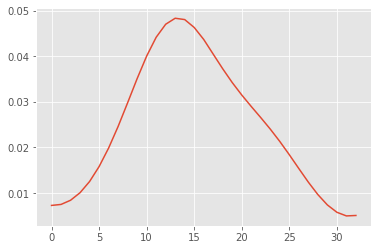

In [ ]:
plt.plot(V[1].T)

In [ ]:
print("The Rank of a Matrix: ", np.linalg.matrix_rank(X))

The Rank of a Matrix:  2


In [ ]:
UV1 = np.outer(U[0], V[0])
UV1.shape

(33, 33)

In [ ]:
UV2 = np.outer(U[1], V[1])
UV2.shape

(33, 33)

In [ ]:
X = UV1 + UV2
X.shape

(33, 33)

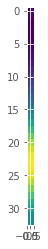

In [ ]:
plt.imshow(U[0].detach().numpy())

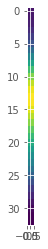

In [ ]:
plt.imshow(U[1].detach().numpy())

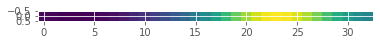

In [ ]:
plt.imshow(V[0].detach().numpy())

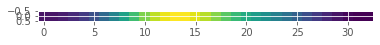

In [ ]:
plt.imshow(V[1].detach().numpy())

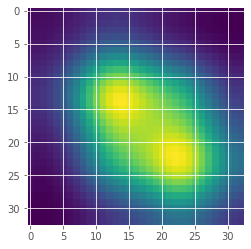

In [ ]:
plt.imshow(X) 

In [ ]:
A, S, B = np.linalg.svd(X)

In [ ]:
S

array([3.78847942e-02, 7.84617104e-03, 5.12915488e-10, 4.88995233e-10,
       4.48293402e-10, 4.13594409e-10, 3.92845922e-10, 3.76213810e-10,
       2.93636171e-10, 2.65080846e-10, 2.33713660e-10, 2.08321513e-10,
       1.84912419e-10, 1.61049007e-10, 1.50599186e-10, 1.38414780e-10,
       1.18562188e-10, 1.11621067e-10, 9.52192908e-11, 9.42882786e-11,
       6.82124565e-11, 6.61019225e-11, 5.31945946e-11, 4.87415143e-11,
       4.10836087e-11, 3.15883639e-11, 2.57819131e-11, 2.21624472e-11,
       1.79807315e-11, 1.26660375e-11, 6.56109542e-12, 4.64395015e-12,
       2.13115051e-12], dtype=float32)

Text(0.5, 1.0, 'Plot of singular values')

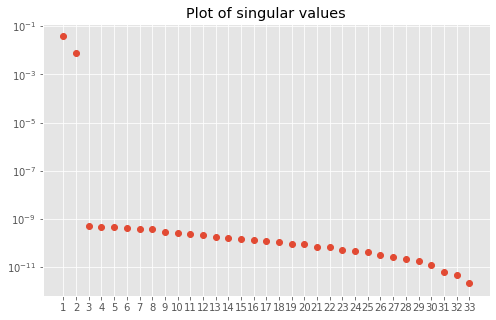

In [ ]:
import matplotlib.pyplot as plt

DEFAULT_FIGSIZE = (8, 5)

plt.figure(figsize=DEFAULT_FIGSIZE)

plt.plot(np.arange(1, len(S) + 1), S, "o")
plt.xticks(np.arange(1, len(S) + 1))
plt.yscale("log")
plt.title("Plot of singular values")


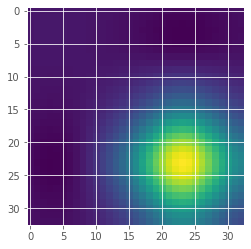

In [ ]:
plt.imshow(UV1)

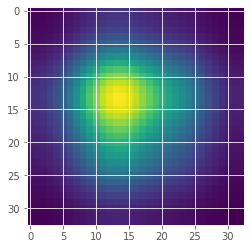

In [ ]:
plt.imshow(UV2)

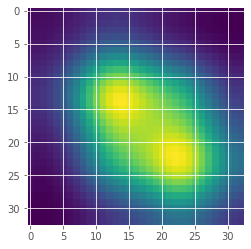

In [ ]:
plt.imshow(X)

In [ ]:
X.shape

(33, 33)

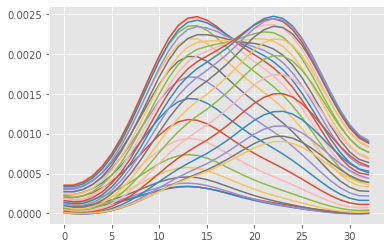

In [ ]:
plt.plot(X)

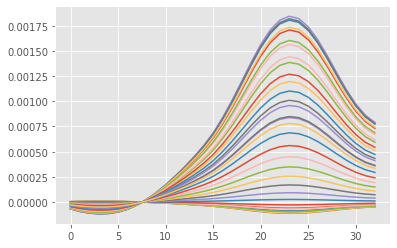

In [ ]:
plt.plot(UV1)

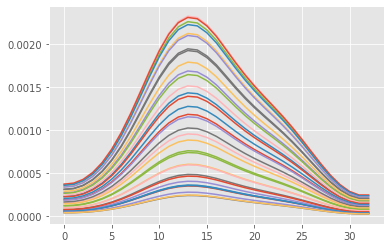

In [ ]:
plt.plot(UV2)